In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [2]:
# Composite DP Mechanism (1) [https://github.com/CompositeDP/CompositeDP]

def float3f(num):
    return float(format(num, '.3f'))


def float2f(num):
    return float(format(num, '.2f'))


# Constraints

def LValue(ep, k, m, y):
    return (1 - k * m) / (2 * y)

def aValue(ep, k, m, y, Cp):
    return (2 * Cp - k * m ** 2) / (2 * k * m)

def checkConstraints(ep, k, m, y, Cp):
    if k <= 0:
        return -1
    if m <= 0:
        return -2
    if y <= 0:
        return -3

    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)

    if k * m >= 1:
        return -4
    if (Cp > k * m * (2 * L - m) / 2) or (Cp < -k * m * (2 * L - m) / 2):
        return -5
    if k > 1 - y:
        return -6
    if k > y * (np.e ** ep - 1):
        return -7
    
    return 0


# Mapping

def range_Cp_fun(ep, k, m, y):
    L = LValue(ep, k, m, y)
    return k * m * (2 * L - m)

def mapping_fromRealToL(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_value = (input_value - lower) * C - L

    return mapped_value

def mapping_inverse_fromLToReal(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_inverse_value = (input_value + L) / C + lower

    return mapped_inverse_value

def listmapping_inverse_fromLToReal(input_list, range_f, lower, ep, k, m, y):
    mapped_inverse_list = []
    for i in range(len(input_list)):
        tmp = mapping_inverse_fromLToReal(input_list[i], range_f, lower, ep, k, m, y)
        mapped_inverse_list.append(tmp)
    return mapped_inverse_list


# Parameter Optimization

def reduceRate(var1, var2):
    rate = (var1 - var2) / var1
    return float(rate)

def H1Rate(ep, k, m, y):
    L = LValue(ep, k, m, y)
    S1 = k*m; S2 = 2*L*y
    return float(S2 / S1)

def H2Rate(Cp, ep, k, m, y):
    L = LValue(ep, k, m, y)
    return 0.33333

def theory_var_fun(ep, k, m, y, Cp_assume):
    Cp = Cp_assume
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    variance = -Cp ** 2 + 2 * L ** 3 * y / 3 + a ** 2 * k * m + a * k * m ** 2 + k * m ** 3 / 3
    return float(variance)

def parameter_optimization(ep):
    step1 = 0.1
    step2 = 0.01
    step3 = 0.001
    k_best = 0
    m_best = 0
    y_best = 0
    reduceRate_best = -1000

    y_upper = 1
    k_upper = 1
    m_upper = 2

    # First round step1
    y_count = 0
    while (y_count < y_upper):
        k_count = 0
        while (k_count < k_upper):
            m_count = 0
            while (m_count <= m_upper):
                if y_count == 0:
                    m_count = m_count + step1
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step1
            k_count = k_count + step1
        y_count = y_count + step1

    # Second round step2
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.1
    else:
        y_count = y_best - step1
        y_count_end = y_best + step1
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.1
        else:
            k_count = k_best - step1
            k_count_end = k_best + step1
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.1
            else:
                m_count = m_best - step1
                m_count_end = m_best + step1
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step2
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step2
            k_count = k_count + step2
        y_count = y_count + step2

    # Third round step3
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.01
    else:
        y_count = y_best - step2
        y_count_end = y_best + step2
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.01
        else:
            k_count = k_best - step2
            k_count_end = k_best + step2
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.01
            else:
                m_count = m_best - step2
                m_count_end = m_best + step2
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step3
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step3
            k_count = k_count + step3
        y_count = y_count + step3

    return k_best, m_best, y_best


# Perturbation Mechanism

def PDF_fun(x, ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    P = 0
    if (x >= -L) and (x < a):
        P = y
    if (x >= a) and (x < a + m):
        P = y + k
    if (x >= a + m) and (x <= L):
        P = y
    return float3f(P)

def generate_perturbed_list(ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    t = (y + k) / np.e ** ep

    divid = 10000
    step = 2 * L / divid
    x_count = -L
    X_axis = []
    P_axis = []
    Perturbed_list = []

    while (x_count <= L):
        P_x = PDF_fun(x_count, ep, k, m, y, Cp)
        P_axis.append(P_x)
        X_axis.append(x_count)
        x_count = x_count + step

    for i in range(len(X_axis)):
        rp = P_axis[i]
        rp = int(rp * 1000)
        for j in range(rp):
            Perturbed_list.append(X_axis[i])

    random.shuffle(Perturbed_list)
    return Perturbed_list

def CDPM(ep, fd, range_f, lower):
    k_best, m_best, y_best = parameter_optimization(ep)
    Cp = mapping_fromRealToL(fd, range_f, lower, ep, k_best, m_best, y_best)
    O_perturbed = generate_perturbed_list(ep, k_best, m_best, y_best, Cp)
    Out_perturbed = listmapping_inverse_fromLToReal(O_perturbed, range_f, lower, ep, k_best, m_best, y_best)

    return Out_perturbed[0]

In [3]:
# Laplace Mechanism

def LM(epsilon, fx, sensitivity):
    z = np.random.laplace(0,sensitivity/epsilon,1)
    return fx+z

In [4]:
# Central Piecewise Mechanism for a numeric query

def eta(c,l,r):
    return (2/r)*c - (2*l+r)/r

def inverse_eta(z,l,r):
    return (r/2)*z + (2*l+r)/2

def CPM(epsilon, fx, l, r, sensitivity):
    # Mapping Step
    t = eta(fx,l,r)
    tild_sensitivity = (2/r)*sensitivity
    m = 0
    while(1):
        if m < 2/tild_sensitivity <= m+1:
            break
        else:
            m += 1
    
    # Perturbation Step
    A = tild_sensitivity*(math.exp(epsilon)*(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1))
    B = (1 + m*tild_sensitivity)*math.exp((m+1)*epsilon)
    U = epsilon/math.log((A + math.sqrt(A**2 + 4*B))/2)
    b = ((m+3)/(m+4))*U
    
    q = (math.exp(epsilon/b)/(2*((math.exp(epsilon/b)+1)**2)*(math.exp(epsilon)-1)))*((math.exp(epsilon)-1)*(math.exp((m+1)*epsilon)-1)-tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*(m*math.exp((m+1)*epsilon)-(m+1)*math.exp(m*epsilon)+1))
    X = math.exp((m+1)*epsilon)/(2*q*(math.exp(epsilon/b)+1))
    Y = np.zeros(m+2)
    for j in range(1,m+2):
        Y[j] = (1/(2*q))*(math.exp(epsilon/b)/(math.exp(epsilon/b)+1))*(1+tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*((m+1-j)*math.exp(m*epsilon)-(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1)))
    D = X + Y[1]
    
    u = random.uniform(0,1)
    flag = 0
    if u < (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D):
        tt = random.uniform(-D,X*t-Y[1])
        flag = 1
    p = q/math.exp((m+1)*epsilon)
    for j in range(1,m+1):
        p += (q/math.exp((m+1-j)*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t-Y[j],X*t-Y[j+1])
            flag = 1
    p += q*2*Y[m+1]
    if flag == 0 and u < p:
        tt = random.uniform(X*t-Y[m+1],X*t+Y[m+1])
        flag = 1
    for j in range(1,m+1):
        p += (q/math.exp(j*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t+Y[m+2-j],X*t+Y[m+1-j])
            flag = 1
    if flag == 0:
        tt = random.uniform(X*t+Y[1],D)
        flag = 1
    
    # Inverse Mapping
    p_fx = inverse_eta(tt,l,r)
    
    return p_fx

In [5]:
def accuracy(m):
    l = 0; r = 1; sensitivity = 1/(m+1)
    diff = np.zeros((9,3))
    epsilon = [i+2 for i in range(9)]
    
    fx = random.uniform(0,1)
    for i in range(9):
        diff[i][0] = math.fabs(CPM(epsilon[i], fx, l, r, sensitivity)-fx)
        diff[i][1] = math.fabs(LM(epsilon[i], fx, sensitivity)-fx)
        diff[i][2] = math.fabs(CDPM(epsilon[i], fx, r, 0)-fx)
    
    return diff

[[0.28469317 0.09444499 0.50324353]
 [0.21064842 0.59965602 0.18576764]
 [0.01046896 0.47243894 0.04838263]
 [0.08676429 0.02983045 0.0433376 ]
 [0.05234876 0.0878212  0.05258269]
 [0.02413469 0.01194414 0.02588224]
 [0.00651959 0.08410333 0.07830634]
 [0.00918139 0.1044297  0.01660136]
 [0.00915696 0.00780211 0.00709989]]
[[0.14453903 1.07040302 1.23594544]
 [0.42755203 0.23926702 0.11875951]
 [0.55036533 0.05763456 0.67482619]
 [0.46174967 0.2584555  0.05723764]
 [0.06863486 0.08242773 0.04012957]
 [0.01437635 0.19769474 0.02989894]
 [0.02849953 0.16174301 0.01155127]
 [0.01095355 0.11432174 0.0356872 ]
 [0.0168317  0.01652316 0.0307139 ]]
[[0.83776982 0.28463253 0.25741048]
 [0.08958852 0.11409252 0.17969059]
 [0.08220347 0.00781976 0.04695046]
 [0.04310888 0.04343233 0.03322757]
 [0.0596114  0.2880168  0.00122588]
 [0.00376192 0.24410605 0.02540996]
 [0.01494152 0.13519492 0.03116203]
 [0.02212668 0.00721882 0.02013159]
 [0.01167756 0.15008732 0.0319627 ]]
[[0.25855836 1.22695617 0

[[0.12686201 0.20085094 0.54032437]
 [0.10519888 0.00094403 0.01132311]
 [0.05197514 0.49562632 0.01358384]
 [0.02487352 0.02577377 0.02951095]
 [0.02007653 0.00609248 0.06602753]
 [0.03827063 0.16936403 0.02557785]
 [0.01559322 0.17068216 0.00788545]
 [0.02459438 0.19287423 0.03339682]
 [0.01360818 0.28037799 0.00493671]]
[[8.74257457e-01 1.64570240e+00 2.29268859e-01]
 [5.96962596e-02 5.27789936e-01 2.16031394e-01]
 [6.00418151e-02 2.72899103e-01 5.52925833e-02]
 [2.81501842e-02 1.76378798e-02 2.08969844e-02]
 [2.66079314e-02 4.17352962e-02 2.23009286e-02]
 [4.69023629e-02 2.19508358e-01 2.30339703e-02]
 [2.47968199e-02 9.48246478e-02 2.29247580e-02]
 [7.79798527e-04 4.09210893e-01 2.93889998e-03]
 [1.24658298e-02 2.64348454e-01 2.38181230e-02]]
[[0.04266565 0.09708595 0.14625155]
 [0.0634869  0.0604025  1.10740435]
 [0.04061425 0.00157172 0.14663464]
 [0.04057251 0.06225244 0.05132287]
 [0.01584548 0.43043679 0.06167272]
 [0.02169022 0.11237242 0.01837325]
 [0.00833764 0.1405839  0.

[[0.05461004 0.11211854 0.00486439]
 [0.04960232 0.25293348 0.00791328]
 [0.01341473 0.08377669 0.11119817]
 [0.71616183 0.27055362 0.00329018]
 [0.06941844 0.06722578 0.00430611]
 [0.00172257 0.04087284 0.02229355]
 [0.02833465 0.1310277  0.03733639]
 [0.01691169 0.11367226 0.01901718]
 [0.00760337 0.27771054 0.03493372]]
[[1.28454933e-01 2.77099558e-02 1.21716098e+00]
 [1.39755648e-01 2.77078797e-01 4.97497676e-02]
 [7.61499030e-02 3.61782701e-01 1.10180576e-01]
 [5.94504322e-02 8.70586263e-04 5.06114004e-02]
 [8.06291011e-03 1.19202507e-01 4.65609355e-02]
 [4.47835003e-02 2.78999091e-02 6.34455469e-03]
 [1.98347399e-02 1.77294455e-01 1.53887007e-02]
 [2.35314716e-03 3.16899122e-02 3.09173309e-02]
 [1.20089599e-03 4.26736916e-01 4.20569894e-02]]
[[0.2138942  0.49066349 0.03560074]
 [0.19124836 0.04931247 0.09071343]
 [0.02085198 0.66426826 0.08442215]
 [0.01330245 0.45174761 0.03769012]
 [0.0545368  0.31316447 0.02075908]
 [0.01661053 0.19835426 0.01396768]
 [0.00812611 0.03180036 0.

[[1.87456481e-01 8.43171633e-01 1.84247946e+00]
 [4.07870274e-01 1.62047044e-01 7.05910830e-01]
 [8.52158849e-04 2.06824791e-01 4.61713870e-03]
 [2.36903265e-02 2.24793489e-01 9.93571780e-03]
 [4.16509525e-02 1.37042662e-01 3.82926856e-02]
 [2.49764509e-02 2.28210151e-02 1.56312610e-02]
 [8.81840602e-03 4.35359820e-02 2.04366039e-02]
 [1.80255274e-02 1.04293405e-01 1.86614133e-02]
 [7.78279885e-03 2.07136655e-01 2.00811737e-02]]
[[1.01926834e-01 6.80427903e-01 4.31887089e-01]
 [1.93004269e-01 3.78917468e-01 2.06241264e-01]
 [1.18411044e-01 1.20958040e-02 3.69055709e-02]
 [7.70886695e-02 7.73768886e-01 6.36140004e-02]
 [5.44297903e-02 3.72919139e-02 3.28653001e-02]
 [2.52123304e-02 6.61902248e-02 3.74344925e-02]
 [3.30967757e-02 1.56821832e-01 3.87450406e-02]
 [2.11959879e-02 6.59571842e-02 6.80613680e-04]
 [1.67843511e-02 5.28117583e-02 3.11001769e-02]]
[[0.32319503 0.15859919 0.11431957]
 [0.1091588  0.09852504 0.52022565]
 [0.14107405 0.12212851 0.08047262]
 [0.08345645 0.15631031 0.

[[0.38884131 0.65909037 0.18151667]
 [0.05037895 0.09735573 0.13479808]
 [0.05845666 0.13690739 0.09453535]
 [0.06556052 0.0058243  0.00551657]
 [0.00452396 0.30568831 0.47330682]
 [0.02546985 0.06534876 0.01446769]
 [0.00610277 0.08115822 0.01086368]
 [0.01921381 0.05230052 0.01829012]
 [0.00080292 0.12321724 0.01938814]]
[[3.56682999e-01 1.13508811e+00 3.63926401e-01]
 [7.48608954e-02 1.42873396e-01 1.84505145e-01]
 [2.02283375e-02 6.99301214e-01 4.61740567e-04]
 [4.02073476e-02 5.68855649e-02 3.88412763e-02]
 [2.34460610e-02 5.02662603e-02 2.49117052e-02]
 [9.88794251e-03 7.12676074e-02 2.21438441e-02]
 [1.63996554e-02 2.98420951e-01 3.53018460e-02]
 [3.31309788e-03 1.14228692e-01 1.14935562e-02]
 [1.14474652e-02 1.53373535e-02 2.68924959e-02]]
[[8.44108547e-02 2.54304048e-01 8.49075476e-01]
 [5.42891848e-02 8.25147711e-01 4.17124704e-03]
 [1.73164969e-01 5.81707129e-02 2.70977883e-02]
 [3.48904955e-02 2.04491861e-01 4.96133993e-02]
 [3.65818659e-02 2.29271719e-01 8.54715208e-03]
 [

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


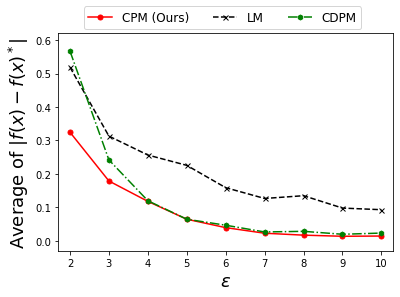

In [6]:
m = 0

diff = np.zeros((9,3))
max_diff = np.zeros((9,3)); min_diff = np.zeros((9,3))
sum_diff = np.zeros((9,3))

jj = 100
for j in range(jj):
    diff = accuracy(m)
    for i in range(9):
        for k in range(3):
            max_diff[i][k] = max(max_diff[i][k], diff[i][k])
            min_diff[i][k] = min(min_diff[i][k], diff[i][k])
            sum_diff[i][k] += diff[i][k]
    print(diff)
diff = sum_diff/jj

y_err = np.zeros((2,9,3))
for k in range(3):
    y_err[0,:,k] = diff[:,k] - min_diff[:,k]
    y_err[1,:,k] = max_diff[:,k] - diff[:,k]
    
epsilon = [i+2 for i in range(9)]

print(diff)
fig = plt.figure()
plt.ylim(-0.03, 0.62)
plt.xlim(1.7, 10.3)
plt.plot(epsilon, diff[:,0], marker="o", markersize=5, color = "red", linestyle = "-", label = "CPM (Ours)")
plt.plot(epsilon, diff[:,1], marker="x", markersize=5, color = "black", linestyle = "dashed", label = "LM")
plt.plot(epsilon, diff[:,2], marker="h", markersize=5, color = "green", linestyle = "dashdot", label = "CDPM")
#plt.errorbar(epsilon, diff[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='red', markeredgecolor = "red", color='red')
#plt.errorbar(epsilon, diff[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='black', markeredgecolor = "black", color='black')
#plt.errorbar(epsilon, diff[:,2], yerr = y_err[:,:,2], capsize=5, fmt='h', ecolor='green', markeredgecolor = "green", color='green')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("$\epsilon$", fontsize = 18)
plt.ylabel("Average of $|f(x) - f(x)^*|$", fontsize = 18)
fig.savefig("Accuracy_single_m=0.png")
fig.savefig("figs/Accuracy_single_m=0.eps", bbox_inches="tight", pad_inches=0.05)